In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Define file paths
ais_tracks_path = '../data/tracks_ais.csv'
radar_tracks_path = '../data/tracks_radar.csv'
radar_detections_path = '../data/detections_radar.csv'

ais_tracks = pd.read_csv(ais_tracks_path)
radar_tracks = pd.read_csv(radar_tracks_path)
radar_detections = pd.read_csv(radar_detections_path)

In [14]:
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2, r = 6371):
    """
    Calculate the distance between two points on the Earth's surface
    using the Haversine formula.

    Args:
        lat1 (float): Latitude of the first point
        lon1 (float): Longitude of the first point
        lat2 (float): Latitude of the second point
        lon2 (float): Longitude of the second point
        r (float): Radius of the Earth in kilometers
    Returns:
        float: circular distance between the two points in kilometers
    """
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return r * c

def circular_mean(angles):
    """
    Calculate the circular mean of a list of angles.
    Args:
        angles(pd series): angles in degress
    Returns:
        float: circular mean of the angles
    """
    angles = angles * np.pi / 180
    x = np.cos(angles)
    y = np.sin(angles)
    return np.arctan2(np.sum(y), np.sum(x))

In [26]:
import warnings

def compute_track_stats(group, KMPS_TO_KNOTS = 1943.84449):
    """
    Takes df of detections for a single track and computes summary statistics.
    """
    assert set([
    'id_detect', 'id_track', 'id_site', 'id_m2', 'source', 'speed','course', 'assoc_str', 'assoc_id', 'confidence', 'cdate', 'ctime',
    'longitude', 'latitude']).issubset(group.columns), (
    "Missing required columns; ensure provided df has all required columns as in radar_detections"
)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        group['datetime'] = pd.to_datetime(group['cdate'] + ' ' + group['ctime'])

    group = group.sort_values(by='datetime').copy()
    start_lat = group['latitude'].iloc[0]
    start_lon = group['longitude'].iloc[0]
    end_lat = group['latitude'].iloc[-1]
    end_lon = group['longitude'].iloc[-1]
    
    
    group['latitude_prev'] = group['latitude'].shift(1)
    group['longitude_prev'] = group['longitude'].shift(1)
    group['time_prev'] = group['datetime'].shift(1)
    group['speed_prev'] = group['speed'].shift(1)

    group['distance_diff'] = haversine_distance(group['latitude_prev'], group['longitude_prev'],group['latitude'], group['longitude']) #spherical distance 
    group['time_diff'] = (group['datetime'] - group['time_prev']).dt.total_seconds() #in second
    group['speed_diff'] = abs(group['speed'] - group['speed_prev']) #abs value

    group['instant_speed'] = group['distance_diff'] / group['time_diff']  # in km/s
    total_distance = group['distance_diff'].sum()
    total_time = (group['datetime'].iloc[-1] - group['datetime'].iloc[0]).total_seconds()

    if total_time <= 0:
        print(f'Problematic track with 0 total time: id_track ={group["id_track"].iloc[0]}')

    # avg_speed = avg_speed_kmps * KMPS_TO_KNOTS
    # max_speed = group['instant_speed'].max() * KMPS_TO_KNOTS
    # min_speed = group['instant_speed'].min() * KMPS_TO_KNOTS

    #Sum stats calculation
    avg_speed = group['speed'].mean() #in knots
    max_speed = group['speed'].max() #in knots
    min_speed = group['speed'].min() #in knots
    total_distance = group['distance_diff'].sum()
    curviness = total_distance / haversine_distance(start_lat, start_lon, end_lat, end_lon)
    
    return pd.Series({
        'assoc_id': group['assoc_id'].iloc[0],
        'avg_speed': avg_speed,
        'max_speed': max_speed,
        'min_speed': min_speed,
        'total_distance': total_distance,
        'curviness': curviness,
        'heading_mean': heading_mean,
        'heading_std': heading_std,
        'turning_mean': turning_mean,
        'turning_std': turning_std
    })


In [37]:
radar_detections['course'].describe()

count    7.387790e+06
mean     2.138922e+02
std      9.488785e+01
min      0.000000e+00
25%      1.578000e+02
50%      1.794000e+02
75%      3.004000e+02
max      3.454300e+03
Name: course, dtype: float64

In [27]:
#Select only radar detections w/ matching records
common_ids = set(radar_tracks['id_track']) & set(radar_detections['assoc_id'])
common_radar_detections = radar_detections[radar_detections['assoc_id'].isin(common_ids)]
common_radar_detections.head(3)

,id_detect,id_track,id_site,id_m2,source,speed,course,assoc_str,assoc_id,confidence,cdate,ctime,longitude,latitude
0,1313152737,29941750,10,83-0702-1140,radar,0.4,66.0,20,29941830,0.996607,2023-07-02,11:40:11,-117.302575,32.815120
1,1313152739,29941750,10,83-0702-1140,radar,0.5,46.9,20,29941830,0.996607,2023-07-02,11:40:17,-117.302553,32.815148
2,1313152741,29941750,10,83-0702-1140,radar,0.5,53.3,20,29941830,0.996607,2023-07-02,11:40:24,-117.302543,32.815150


In [28]:
summary_df = common_radar_detections.groupby('id_track').apply(compute_track_stats).reset_index()

/var/folders/jm/bv3tgs257hx9tx764_p9xq0w0000gn/T/ipykernel_10836/943239562.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = common_radar_detections.groupby('id_track').apply(compute_track_stats).reset_index()


In [29]:
comparison = pd.merge(radar_tracks, summary_df, left_on='id_track', right_on='assoc_id', how='inner')
comparison.columns

Index(['id_track_x', 'id_site', 'id_m2', 'source', 'duration', 'alarm',
       'min_speed_x', 'max_speed_x', 'avg_speed_x', 'curviness_x',
       'heading_mean_x', 'heading_std_x', 'turning_mean_x', 'turning_std_x',
       'duration_z', 'distance', 'distance_o', 'assoc_str', 'assoc_id_x',
       'tagged', 'has_photos', 'confidence', 'detections', 'mmsi', 'type',
       'dim_a', 'dim_b', 'dim_c', 'dim_d', 'draft', 'dest', 'eta_month',
       'eta_day', 'eta_hour', 'eta_minute', 'type_m2', 'sdate', 'stime',
       'ldate', 'ltime', 'id_track_y', 'assoc_id_y', 'avg_speed_y',
       'max_speed_y', 'min_speed_y', 'total_distance', 'curviness_y',
       'heading_mean_y', 'heading_std_y', 'turning_mean_y', 'turning_std_y'],
      dtype='object')

### Plotting to Check Consistency

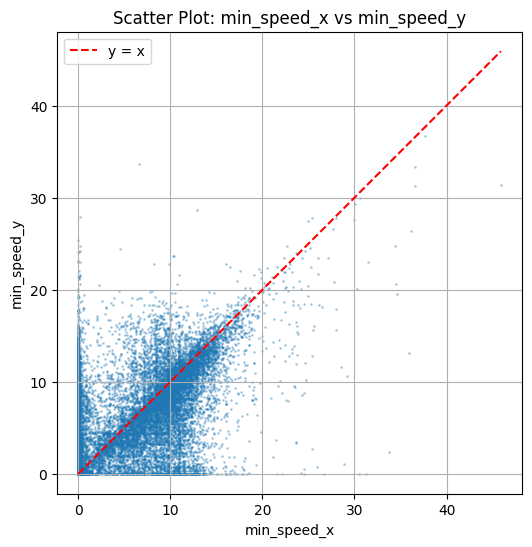

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(comparison['min_speed_x'], comparison['min_speed_y'], alpha=0.3, s = 1)

# y = x reference line
min_val = min(comparison['min_speed_x'].min(), comparison['min_speed_y'].min())
max_val = max(comparison['min_speed_x'].max(), comparison['min_speed_y'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

# Labels and title
plt.xlabel('min_speed_x')
plt.ylabel('min_speed_y')
plt.title('Scatter Plot: min_speed_x vs min_speed_y')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Keeps x and y scale the same

plt.show()


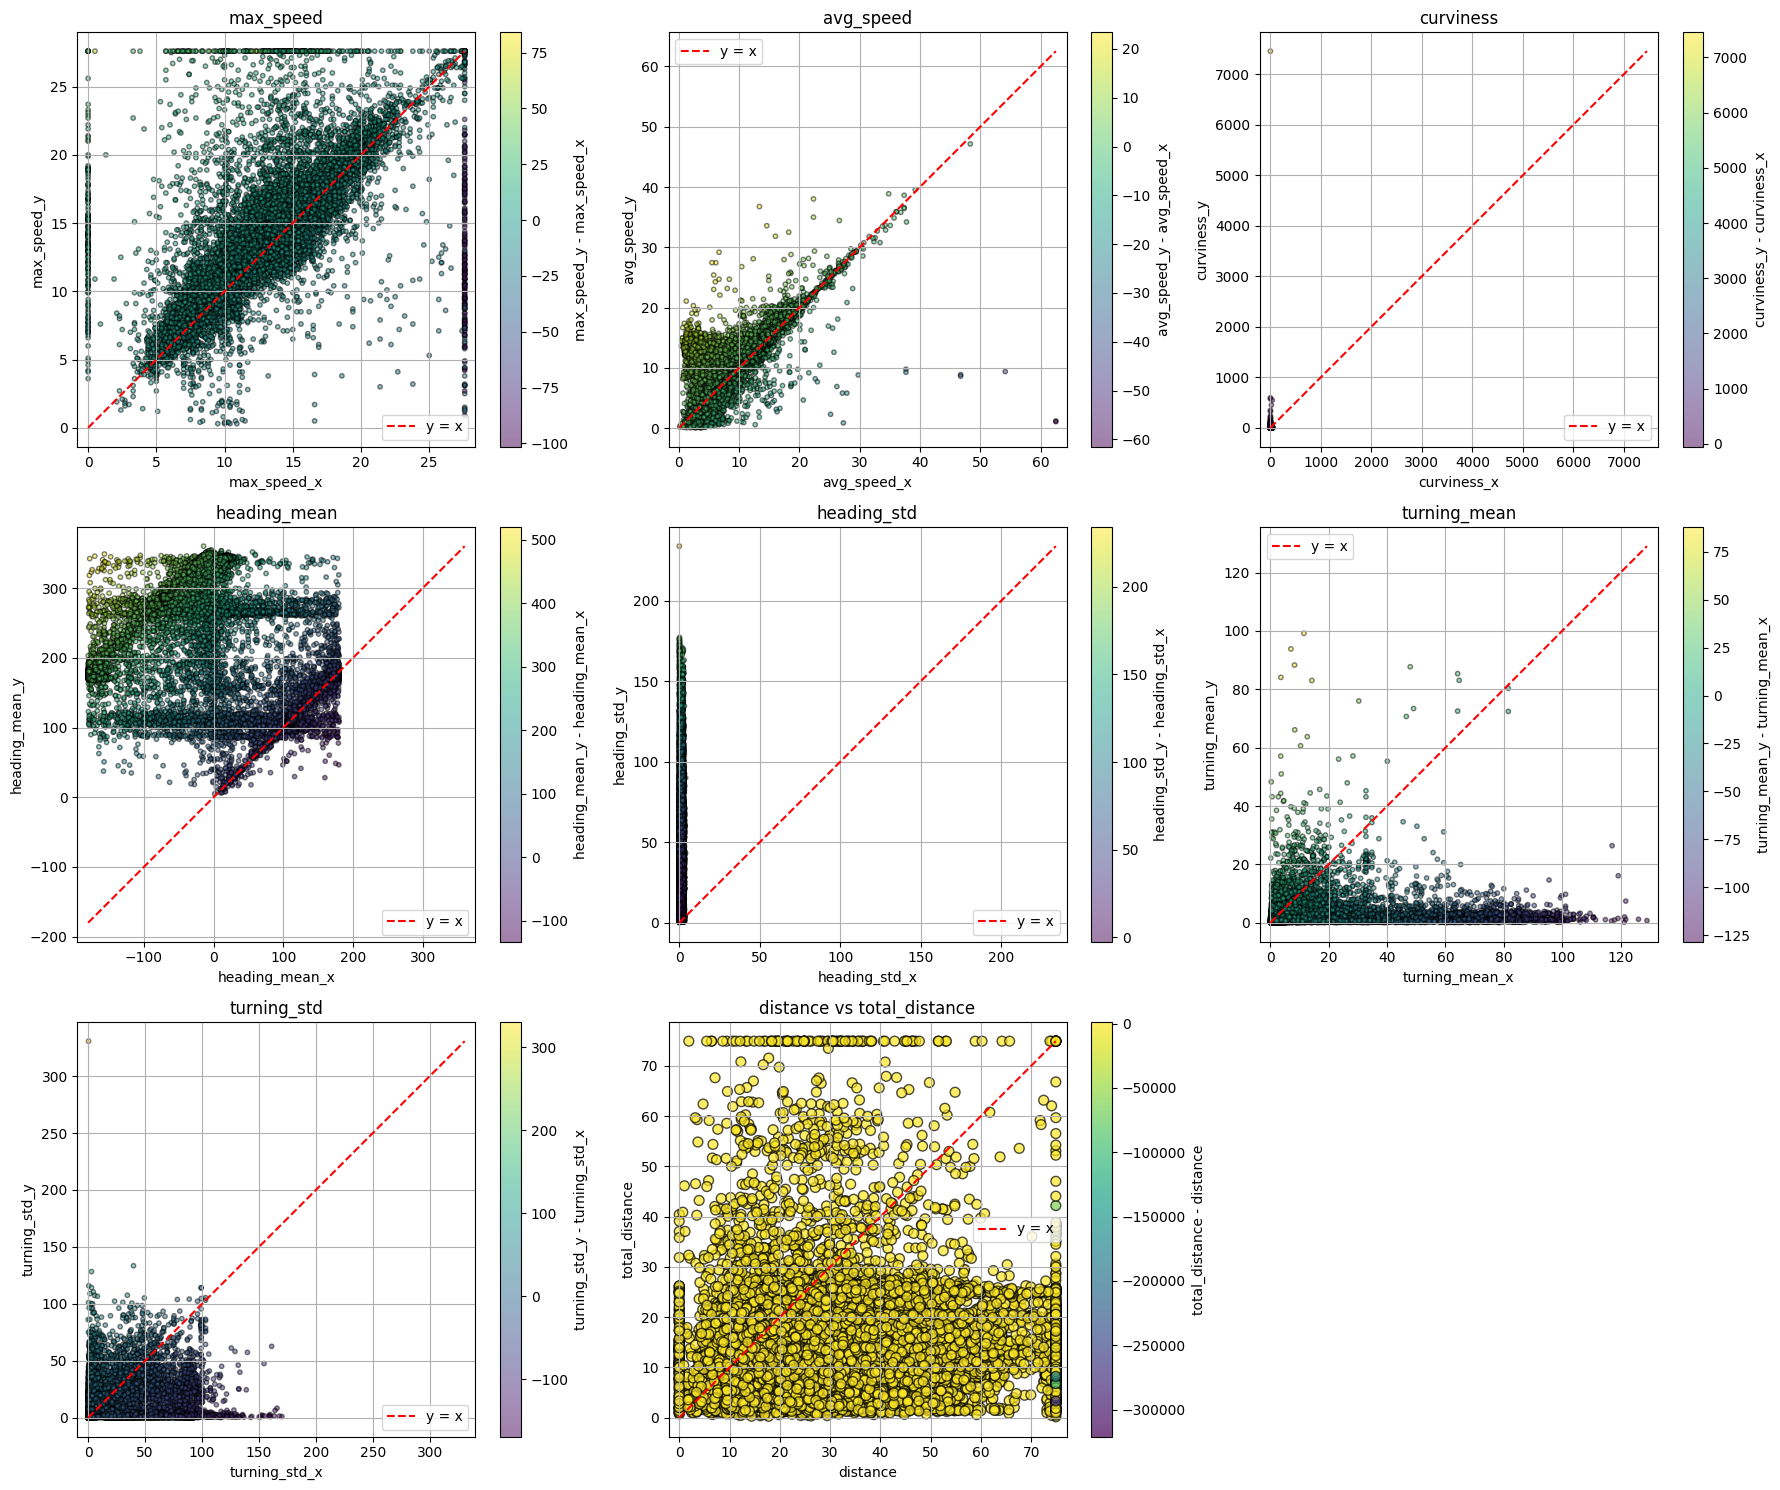

In [34]:
import matplotlib.pyplot as plt
import numpy as np

variables = [
    'max_speed', 'avg_speed', 'curviness',
    'heading_mean', 'heading_std',
    'turning_mean', 'turning_std'
]

n_cols = 3
n_rows = (len(variables) + 1 + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 5 * n_rows))

for i, var in enumerate(variables):
    x = comparison[f'{var}_x']
    y = comparison[f'{var}_y']
    color = y - x

    # Cap values at 98th percentile
    cap = np.percentile(np.concatenate([x, y]), 98)
    x_clipped = np.clip(x, None, cap)
    y_clipped = np.clip(y, None, cap)

    plt.subplot(n_rows, n_cols, i + 1)
    scatter = plt.scatter(
        x_clipped, y_clipped,
        c=color, cmap='viridis', s=10, alpha=0.5, edgecolor='k'
    )

    min_val = min(x_clipped.min(), y_clipped.min())
    max_val = max(x_clipped.max(), y_clipped.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

    plt.xlabel(f'{var}_x')
    plt.ylabel(f'{var}_y')
    plt.title(var)
    plt.colorbar(scatter, label=f'{var}_y - {var}_x')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()

# Special case: distance vs total_distance
x = comparison['distance']
y = comparison['total_distance']
color = y - x

cap = np.percentile(np.concatenate([x, y]), 98)
x_clipped = np.clip(x, None, cap)
y_clipped = np.clip(y, None, cap)

plt.subplot(n_rows, n_cols, len(variables) + 1)
scatter = plt.scatter(
    x_clipped, y_clipped,
    c=color, cmap='viridis', s=50, alpha=0.7, edgecolor='k'
)

min_val = min(x_clipped.min(), y_clipped.min())
max_val = max(x_clipped.max(), y_clipped.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel('distance')
plt.ylabel('total_distance')
plt.title('distance vs total_distance')
plt.colorbar(scatter, label='total_distance - distance')
plt.axis('equal')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
radar_tracks['heading_mean'].describe()

count    27268.000000
mean        20.438305
std        108.639327
min       -179.989612
25%        -66.463140
50%          6.026796
75%        116.728003
max        179.999698
Name: heading_mean, dtype: float64